In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from tqdm.notebook import tqdm

from src.binary_engine_legacy import GFlowBinaryEngine
from src.functional import correlation_for_all_neurons, sigmoid
from src.model import FlowModel
from src.simulators import NetworkSystemSimulator
from src.utils import plot_neural_activity
from src.gflownet_functions import get_all_binary_matrices, get_parents_flow_binary

In [2]:
F_sa = FlowModel(3, 512)
F_sa.to("cuda")
F_sa.eval()
simulator = NetworkSystemSimulator(device="cuda")
engine = GFlowBinaryEngine(F_sa, simulator, device="cuda")

In [3]:
get_parents_flow_binary(torch.tensor([1., 0, 1, 0, 0, 0, 0, 1, 0]), F_sa)

flow: 0.5148553848266602 -> parent = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
flow: 1.02899968624115 -> parent = tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.])
flow: 0.521050214767456 -> parent = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
flow: 0.9964465498924255 -> parent = tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.])
flow: 2.5179738998413086 -> parent = tensor([0., 0., 1., 0., 0., 0., 0., 1., 0.])
flow: 0.5148553848266602 -> parent = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
flow: 1.0045404434204102 -> parent = tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.])
flow: 0.5037842988967896 -> parent = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
flow: 1.0424904823303223 -> parent = tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.])
flow: 2.5485525131225586 -> parent = tensor([1., 0., 0., 0., 0., 0., 0., 1., 0.])
flow: 0.521050214767456 -> parent = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
flow: 1.035344123840332 -> parent = tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.])
flow: 0.5037842988967

tensor(7.6074, device='cuda:0', grad_fn=<AddBackward0>)

In [13]:
_, presampled_flows = get_all_binary_matrices(9, F_sa)
freq_before = {i: 0 for i in range(512)}
for _ in tqdm(range(500)):
    matrix = engine(torch.zeros(3, 100, device="cuda"), presampled_flows).detach().cpu().int().flatten().tolist()
    binary = "".join([str(i) for i in matrix])
    matrix_id = int(binary, 2)
    freq_before[matrix_id] += 1

  0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(512)), y=list(freq_before.values())))
fig.update_layout(
    title="Frecuencia de muestreo de cada matriz (500 muestras) ANTES de entrenar",
    xaxis_title="ID Matriz",
    yaxis_title="Frecuencia",
)
fig.show()

In [2]:
F_sa = FlowModel(3, 512)
F_sa.to("cuda")
F_sa.eval()
F_sa.load_state_dict(torch.load("training/binary/5epoch_no_diag_3x3_more_force/model.pt", weights_only=True))
simulator = NetworkSystemSimulator(device="cuda")
engine = GFlowBinaryEngine(F_sa, simulator, device="cuda")

In [3]:
_, presampled_flows = get_all_binary_matrices(9, F_sa)
freq_after = {i: 0 for i in range(512)}
for _ in tqdm(range(500)):
    matrix = engine(torch.zeros(3, 100, device="cuda"), presampled_flows).detach().cpu().int().flatten().tolist()
    binary = "".join([str(i) for i in matrix])
    matrix_id = int(binary, 2)
    freq_after[matrix_id] += 1

  0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(512)), y=list(freq_after.values())))
fig.update_layout(
    title="Frecuencia de muestreo de cada matriz (500 muestras) DESPUÉS de entrenar",
    xaxis_title="ID Matriz",
    yaxis_title="Frecuencia",
)
fig.show()

In [5]:
torch.manual_seed(0)
x0 = torch.rand(3, device="cuda")
org_simulation = simulator.simulate_neurons((torch.ones(3, 3) - torch.eye(3)).cuda(), timesteps=100, initial_value=x0)
matrices, _ = get_all_binary_matrices(9, F_sa)
rewards = []
for matrix in matrices:
    matrix_cuda = matrix.cuda().reshape(3, 3)
    simulation = simulator.simulate_neurons(matrix_cuda, timesteps=100, initial_value=x0)
    rewards.append(r := engine.reward_function(org_simulation, simulation, matrix=matrix_cuda, kernel_width=0.1))
    print(r, torch.diag(matrix.reshape(3, 3)))

tensor(0.) tensor([0., 0., 0.], device='cuda:0')
tensor(0.) tensor([0., 0., 1.], device='cuda:0')
tensor(0.) tensor([0., 0., 0.], device='cuda:0')
tensor(0.) tensor([0., 0., 1.], device='cuda:0')
tensor(0.) tensor([0., 0., 0.], device='cuda:0')
tensor(0.) tensor([0., 0., 1.], device='cuda:0')
tensor(0.) tensor([0., 0., 0.], device='cuda:0')
tensor(0.) tensor([0., 0., 1.], device='cuda:0')
tensor(0.) tensor([0., 0., 0.], device='cuda:0')
tensor(0.) tensor([0., 0., 1.], device='cuda:0')
tensor(0.) tensor([0., 0., 0.], device='cuda:0')
tensor(0.) tensor([0., 0., 1.], device='cuda:0')
tensor(0.) tensor([0., 0., 0.], device='cuda:0')
tensor(0.) tensor([0., 0., 1.], device='cuda:0')
tensor(0.) tensor([0., 0., 0.], device='cuda:0')
tensor(0.) tensor([0., 0., 1.], device='cuda:0')
tensor(0.) tensor([0., 1., 0.], device='cuda:0')
tensor(0.) tensor([0., 1., 1.], device='cuda:0')
tensor(0.) tensor([0., 1., 0.], device='cuda:0')
tensor(0.) tensor([0., 1., 1.], device='cuda:0')
tensor(0.) tensor([0

In [6]:
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(512)), y=[reward.detach().cpu() for reward in rewards]))
# fig.add_trace(go.Bar(x=[273], y=[rewards[273].detach().cpu()]))
fig.update_layout({
    "title": "Reward for every matrix"
})
fig.show()

<BarContainer object of 512 artists>

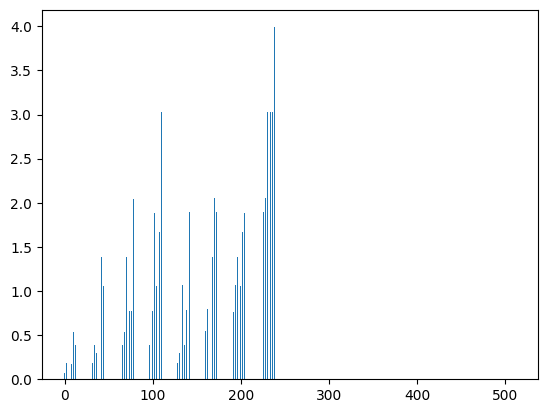

In [14]:
plt.bar(range(512), [reward.detach().cpu() for reward in rewards])